In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 189 kB 16.0 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 48 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 558 kB 46.8 MB/s 
     |████████████████████████████████| 51 kB 310 kB/s 
     |████████████████████████████████| 130 kB 49.0 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# "Pixel Similarity vs. Basic Neural Net on the MNIST data set"
> "Comparing two digit classifiers: a "similarity" approach and a 3 layer neural network."

- categories: [vision]

## Pixel similarity
We will take the average of each digit to get its "perfect" version. Then, we compare an image to each of those perfect numbers and see which one is the most similar. 

First, we'll download the MNIST dataset:

In [28]:
path = untar_data(URLs.MNIST)

The dataset is separated into training and testing subfolders, where in those folders, there are separate folders for each digit:

In [29]:
Path.BASE_PATH = path

In [30]:
path.ls(),(path/'training').ls()

((#2) [Path('testing'),Path('training')],
 (#10) [Path('training/7'),Path('training/8'),Path('training/1'),Path('training/6'),Path('training/3'),Path('training/2'),Path('training/5'),Path('training/4'),Path('training/0'),Path('training/9')])

We'll store the path of each image in an array, where the `i`th row contains the path for the `i`th digit:

In [31]:
nums = [(path/'training'/f'{x}').ls().sorted() for x in range(10)]

In [32]:
im3_path = nums[3][0]
im3 = Image.open(im3_path)
im3

Then, we'll open the images, put every image of the same digit into their own tensor and store them as a list of tensors:

In [33]:
nums_tens = [torch.stack([tensor(Image.open(j)) for j in nums[i]]) for i in range(10)]
nums_tens = [nums_tens[i].float()/255 for i in range(10)]

We can then take the mean of one of the tensors to get its "perfect" version. Here is how it looks like for a `3`:

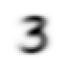

In [34]:
stacked_threes = nums_tens[3].mean(0)
show_image(stacked_threes)

And to compare, here is just one of those threes:

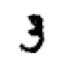

In [35]:
a_3 = nums_tens[3][0]
show_image(a_3)

Next, we'll create a function that compares two tensors through absolute mean difference:

In [37]:
def mnist_distance(x1, x2): 
    return (x1 - x2).abs().mean((-1, -2))

Now we can compare one of the threes with its "perfect" version. The number doesn't really mean anything until we compare it with another number:

In [38]:
mnist_distance(a_3, stacked_threes)

tensor(0.1074)

So, we'll take the average seven and take the L1 norm (absolute mean difference) and compare that number with the number we just got (`0.1074`)

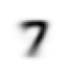

In [39]:
stacked_sevens = nums_tens[7].mean(0)
show_image(stacked_sevens)

In [40]:
mnist_distance(a_3, stacked_sevens)

tensor(0.1441)

As you can see, the distance between the `3` and the average `3` is smaller than the distance between the `3` and the average `7`. So, it is *more three than seven*. We'll extend this approach by comparing an image with the average for each digit and say it is the digit it is the most similar to (its L1 norm with that average digit is the smallest).

We'll create the average number for each digit:

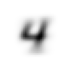

In [41]:
stacked_nums = [nums_tens[i].mean(0) for i in range(10)]
show_image(stacked_nums[4])

We can compare our `3` to each average digit:

In [42]:
L(mnist_distance(a_3, stacked_nums[i]) for i in range(10))

(#10) [tensor(0.1750),tensor(0.1153),tensor(0.1501),tensor(0.1074),tensor(0.1635),tensor(0.1326),tensor(0.1579),tensor(0.1441),tensor(0.1345),tensor(0.1402)]

As you can see, it is most similar to the average three.

Now we'll import the validation set and put them into a list of tensors:

In [43]:
valid_nums = [(path/'testing'/f'{i}').ls().sorted() for i in range(10)]

In [44]:
valid_nums_tens = [torch.stack([tensor(Image.open(j)) for j in valid_nums[i]]) for i in range(10)]
valid_nums_tens = [valid_nums_tens[i].float()/255 for i in range(10)]

We'll create a function that returns the accuracy of our whole process:

In [45]:
def is_num(x1, x2s, x):
    # Get the distance between the number and the average digit for each digit
    vals = [mnist_distance(x1, x2s[i]) for i in range(10)]

    # Turn the tensors into floats so that we can perform the `min` function
    vals_2 = [[vals[i][j].item() for i in range(10)] for j in range(len(x1))]

    # Get a list of tensors that contain a bool value, where it's true when
    # the minimum distance is equal to the digit the given number is supposed
    # to be
    vals_3 = [tensor(vals_2[i].index(min(vals_2[i])) == x) for i in range(len(x1))]

    # Return how often our model is correct
    return tensor(vals_3).float().mean(0)

In [46]:
nums_accuracy = tensor([is_num(valid_nums_tens[i], stacked_nums, i) for i in range(10)])
nums_accuracy, nums_accuracy.mean(0)

(tensor([0.8153, 0.9982, 0.4234, 0.6089, 0.6680, 0.3262, 0.7871, 0.7646, 0.4425, 0.7760]),
 tensor(0.6610))

Our model has an overall accuracy of `66.1%`! Better than a random guess of `10%`, but certainly not good. It is particularly good at guessing if a number is a `1`, but particularly bad for `2`s, `5`s and `8`s.

Now that we have a baseline, we can try how good we can get a simple model "from scratch."

# Basic neural network

For our "from scratch" learner, we'll have 2 layers, where each layer contains a linear layer and a ReLU (rectified linear unit, where all negative numbers become `0`).

For our loss function, we will be using cross-entropy loss since we have multiple categories.  

First, we'll make our training and validation datasets and dataloaders. Then, we'll initialize parameters, figure out how to make predictions, calculate the loss (cross-entropy), calculate the gradients, and then step (using the provided SGD optimizer). 

Let's first redownload the MNIST dataset:

In [47]:
path = untar_data(URLs.MNIST)

In [48]:
Path.BASE_PATH = path

In [49]:
path.ls()

(#2) [Path('testing'),Path('training')]

Then, we'll save the training and validation images into separate variables:

In [50]:
nums = [(path/'training'/f'{x}').ls().sorted() for x in range(10)]

In [51]:
nums_tens = [torch.stack([tensor(Image.open(j)) for j in nums[i]]) for i in range(10)]
nums_tens = [nums_tens[i].float()/255 for i in range(10)]

In [52]:
valid_nums = [(path/'testing'/f'{i}').ls().sorted() for i in range(10)]

In [53]:
valid_nums_tens = [torch.stack([tensor(Image.open(j)) for j in valid_nums[i]]) for i in range(10)]
valid_nums_tens = [valid_nums_tens[i].float()/255 for i in range(10)]

Next, we'll create our dataset from our training set. A dataset is a list of tuples, which contains the independent variable and its label (dependent variable) like so: `(independent, dependent)`. 

In [12]:
train_x = torch.cat(nums_tens).view(-1, 28*28)

It took a while for me to realize what the `.view()` function was doing, but what it does is pretty simple. We give it however many values we want (that makes sense) to change the shape of our tensor. Here we give it `-1, 28*28` which will turn our rank-3 tensor (`n`-images of 28 by 28) into a rank-2 tensor (`n`-images of 28\*28). `-1` makes it so that we don't have to specify how many images there are and `28*28` means we want to compress our previous `28` by `28` grid into a `28*28` vector. It's like turning a 2D array into a 1D array:

In [54]:
# 
# -1 makes it so that we don't have to know how many images there are
nums_tens[0].view(-1, 28*28).shape, nums_tens[0].view(5923, 28*28).shape

(torch.Size([5923, 784]), torch.Size([5923, 784]))

In [55]:
# 
# before we called .view(), our tensor was originally 28x28, but afterwards, it is 28*28 (784)
nums_tens[0].size(), nums_tens[0].view(-1, 28*28).shape

(torch.Size([5923, 28, 28]), torch.Size([5923, 784]))

We'll form our labels by having as many tensors containing the digit's digit as there are of that digit:

In [56]:
train_y = torch.cat([tensor([i] * len(nums_tens[i])) for i in range(10)])

In [57]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb1e2aa69d0>, tensor(3))

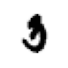

In [59]:
# 
# when we take a random 3, we can index into the labels at the same spot and see
# that we can 3 as its label
show_image(nums_tens[3][200]), train_y[len(nums_tens[0]) + len(nums_tens[1]) + len(nums_tens[2]) +200]

Like I said before, a dataset is just a list of tuples containing our independent and dependent variables:

In [60]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor(0))

And we can see that given a label `0`, our image is indeed a zero:

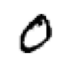

In [61]:
# 
# we have to reshape our image from a 784 long vector into a 28*28 matrix
show_image(x.view(28, 28))

Now we'll make the dataset for our validation set:

In [62]:
valid_x = torch.cat(valid_nums_tens).view(-1, 28*28)
valid_y = torch.cat([tensor([i] * len(valid_nums_tens[i])) for i in range(10)])
valid_dset = list(zip(valid_x, valid_y))

Next, we'll create `DataLoader`s for our training and validation sets. A `DataLoader` takes a dataset and each time we use it, it will give a portion of the dataset. We can then work on a portion of the dataset instead of just 1 tuple or the entire set. We can also toggle whether we want our given portion to be randomize (we wouldn't want to get all `0`s, then `1`s, then `2`s, ... we want a mix):

In [63]:
dl = DataLoader(dset, batch_size = 128, shuffle = True)
valid_dl = DataLoader(valid_dset, batch_size = 128, shuffle = True)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([128, 784]), torch.Size([128]))

Then, we'll create our `DataLoaders`. A `DataLoaders` is like the dataset of a `DataLoader`: it just contains our training and validation `DataLoader`s:

In [65]:
dls = DataLoaders(dl, valid_dl)

Our simple neural network uses PyTorch's `nn.Sequential` which takes modules and uses the GPU to handle the operations:

In [66]:
simple_net = nn.Sequential(
    # Our first layer takes in 28*28 inputs and outputs 250 
    nn.Linear(28 * 28, 250),
    nn.ReLU(),

    # Our second layer takes in 250 inputs and outputs 50
    nn.Linear(250, 50),
    nn.ReLU(),

    # Our final layer takes in 50 inputs and outputs 10
    # (its confidence for our image to be each digit)
    nn.Linear(50, 10)
)

We use cross-entropy loss so that we can turn our 10 outputs into numbers that are from 0 to 1 and sum to 1 like probabilities (through softmax). But, that's just the first part. We then take the negative log (`-log(p)`) of those probabilities to give emphasis on the higher probabilities. 

We'll use the given `Learner` class from fastai (which handles epochs) with the `SGD` optimizer (stochastic gradient descent, which handles calculating gradients and stepping into lower loss) and use the accuracy metric (the number we care about). 

In [67]:
learn = Learner(dls, simple_net, opt_func = SGD, loss_func = F.cross_entropy, metrics = accuracy)

We'll use the learning rate finder to select a good learning rate for us:

SuggestedLRs(valley=0.04786301031708717)

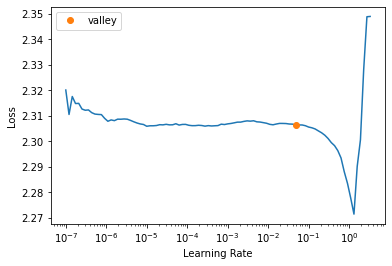

In [68]:
lrs = learn.lr_find()
lrs

In [69]:
learn.fit(20, lr = lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.454874,0.400172,0.889500,00:02
1,0.322119,0.292965,0.916900,00:02
2,0.264725,0.245524,0.929800,00:02
3,0.228520,0.216811,0.938200,00:02
4,0.196191,0.187768,0.945100,00:02
5,0.181299,0.170362,0.950000,00:02
6,0.151747,0.152564,0.954600,00:02
7,0.143972,0.141233,0.957100,00:02
8,0.125890,0.130209,0.961300,00:02
9,0.119570,0.117828,0.964100,00:02


And we see that our final accuracy is `97.5%`! Certainly better than the `66.1%` we got from our pixel similarity approach. 

To compare, here's the results using fastai's provided `cnn_learner` which uses a pretrained model with 18 layers:

In [70]:
dls2 = ImageDataLoaders.from_folder(path, train='training', valid='testing')
learn2 = cnn_learner(dls2, resnet18, loss_func=F.cross_entropy, metrics=accuracy)
learn2.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.124300,0.056642,0.982900,02:04


Our model is not bad considering it's less than `1%` in accuracy different from a pretrained model. 

We could even make our model better by training for more epochs until the validation loss becomes worse or by using a deeper model. 